## Plot feature distribution over time

In [41]:
import pandas as pd

races_df = pd.read_csv("../data/races.csv")

races_df

,Unnamed: 0,date_time,race_id,n_runners,horse_id,current_odds,current_place_odds,place,has_won,relevance,...,Class_Difference,Has_Jockey_Changed,Purse,Average_Place_Lifetime,Average_Place_Track,Does_Head_To_Head,Jockey_Weight,Max_Past_Rating,Weight_Allowance,Average_Place_Surface
0,0,2021-09-30 14:00:00,4462114,7,40276286,3.75,1.69,4,0,15,...,0.0,0.0,7620.000000,3.000000,NaN,0,72.1,99.0,3.2,3.222222
1,1,2021-09-30 14:00:00,4462114,7,40276287,5.50,2.13,5,0,15,...,-1.0,1.0,4125.000000,6.000000,4.000000,0,68.9,NaN,0.0,6.000000
2,2,2021-09-30 14:00:00,4462114,7,40276288,8.50,2.88,2,0,27,...,0.0,1.0,4766.666667,4.500000,NaN,0,68.9,NaN,0.0,9.000000
3,3,2021-09-30 14:00:00,4462114,7,40276289,401.00,101.00,7,0,0,...,0.0,1.0,4700.000000,9.000000,NaN,0,68.9,NaN,0.0,7.500000
4,4,2021-09-30 14:00:00,4462114,7,40276290,67.00,17.50,6,0,0,...,-1.0,1.0,3500.000000,5.000000,NaN,0,68.9,NaN,0.0,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92525,92525,2022-09-01 20:30:00,5325671,10,48202477,3.75,1.55,4,0,26,...,-1.0,1.0,12768.085106,5.127660,1.000000,0,58.1,104.0,0.0,4.903226
92526,92526,2022-09-01 20:30:00,5325671,10,48202478,11.00,3.00,9,0,22,...,0.0,1.0,19355.555556,4.333333,NaN,0,55.3,83.0,0.0,6.000000
92527,92527,2022-09-01 20:30:00,5325671,10,48202479,12.00,3.20,5,0,25,...,-1.0,1.0,13485.714286,3.000000,NaN,0,53.5,80.0,0.0,3.500000
92528,92528,2022-09-01 20:30:00,5325671,10,48202481,10.00,2.80,1,1,30,...,0.0,1.0,24800.000000,4.300000,NaN,0,52.6,NaN,0.0,4.300000


                 std
year-month          
2021-09     7.366602
2021-10     7.018159
2021-11     6.894181
2021-12     6.777769
2022-01     7.194610
2022-02     7.126248
2022-03     6.988836
2022-04     7.479083
2022-05     7.838656
2022-06     8.034916
2022-07     8.158352
2022-08     8.546735
2022-09     8.298306


<AxesSubplot:xlabel='Two_Year_Start_Count', ylabel='year-month'>

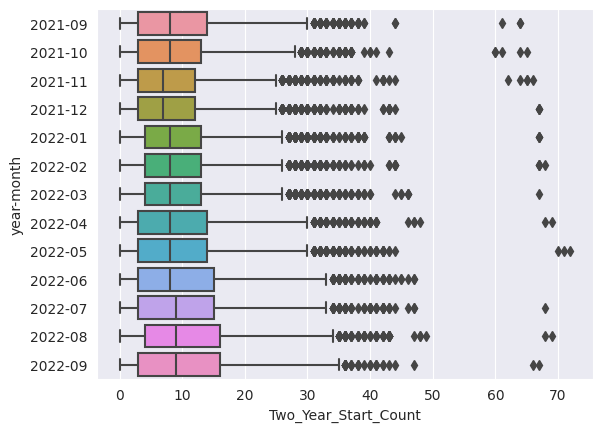

In [42]:
import seaborn as sns

races_df["year-month"] = races_df["date_time"].astype(str).str[:7]
races_df["date"] = pd.to_datetime(races_df["date_time"], format='%Y-%m-%d')
races_df["dayofweek"] = races_df["date"].dt.dayofweek.astype(str)
races_df["hour"] = races_df["date"].dt.hour.astype(str)
races_df["month"] = races_df["date"].dt.month.astype(str)

print(races_df.groupby(["year-month"]).agg(std=("Horse_Win_Rate", "std")))

sns.boxplot(data=races_df, x="Horse_Win_Rate", y="year-month")

# Covariate Shift Detection

## 1.) Between a month and its predecessor

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

races_df = pd.read_csv("../data/races.csv")
races_df["year-month"] = races_df["date_time"].astype(str).str[:7]

month_df = races_df[races_df["year-month"].isin(["2022-09", "2022-08"])]
month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)

month_df = month_df.fillna(value=-1)

month_df = month_df.drop(["date_time", "race_id", "horse_id", "year-month", "Month_Sin", "Month_Cos", "Unnamed: 0"], axis=1)

print(month_df)

features = [column for column in month_df.columns if column not in ["label"]]
shift_X = month_df.loc[:, features]
scaler = StandardScaler().fit(shift_X)
shift_X = scaler.transform(shift_X)

shift_y = month_df.loc[:, "label"]

X_train, X_test, y_train, y_test = train_test_split(shift_X, shift_y, test_size=0.33, random_state=42, stratify=shift_y)

log_regression_classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
print(f"Classifier score:{log_regression_classifier.score(X_test, y_test)}")

coef_data = {
    "feature name": list([column for column in features]),
    "coeff": list(list(log_regression_classifier.coef_)[0]),
}

coeff_df = pd.DataFrame.from_dict(coef_data)
coeff_df.sort_values(by=["coeff"])

       n_runners  current_odds  current_place_odds  place  has_won  relevance  \
80410         11          4.20                1.64      6        0         27   
80411         11         67.00               14.20      9        0         25   
80412         11         15.00                3.80      3        0         30   
80413         11         41.00                9.00     11        0         17   
80414         11         12.00                3.20      4        0         29   
...          ...           ...                 ...    ...      ...        ...   
92525         10          3.75                1.55      4        0         26   
92526         10         11.00                3.00      9        0         22   
92527         10         12.00                3.20      5        0         25   
92528         10         10.00                2.80      1        1         30   
92529         10         17.00                4.20      3        0         29   

       Current_Odds_Feature

/tmp/ipykernel_8287/2015652303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)


,feature name,coeff
12,Draw_Bias,-0.377124
10,Age,-0.294436
1,current_odds,-0.280174
6,Current_Odds_Feature,-0.280174
11,Current_Rating,-0.240611
18,Hour_Cos,-0.177859
8,Current_Race_Class,-0.164490
14,Current_Race_Track,-0.159514
48,Average_Place_Surface,-0.119077
45,Jockey_Weight,-0.095458
